In [73]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [289]:
from camera.core import emergence

In [384]:
traj_dir = '../media/trajectories/'
groups   = [ 'A2', 'A3', 'A4', 'A5', 'A6', 'A8', 'A9', 'A10',
             'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9' ]
bufs = [ 36 ] * 3 + [ 60 ] * 5 + [ 60 ] * 9
bufs = dict(zip(groups, bufs))
         
FPS = 12

## Downsample and interpolate trajectory data

Grab the trajectories, downsample them, then interpolate using `scipy` to obtain position data. 

See this [SO](https://stackoverflow.com/questions/14244289/scipy-interpolating-trajectory) for details of implementation. Interpolation fails if two data points are too close to each-other, so some filtering of data may need to be done in places. See this [SO](https://stackoverflow.com/questions/47948453/scipy-interpolate-splprep-error-invalid-inputs) for details.

In [206]:
def correct_for_interp(traj):
    # to avoid interpolating error make sure there are no identical consecutive values
    x1_down = traj[:, 0]
    x2_down = traj[:, 1]
    filt = np.where(np.abs(np.diff(x1_down)) + np.abs(np.diff(x2_down)) > 0)
    skip = len(x1_down) - len(filt[0])
    x1_down = np.r_[x1_down[filt], x1_down[-skip:]]
    x2_down = np.r_[x2_down[filt], x2_down[-skip:]]
    
    return np.vstack([x1_down, x2_down]).T


In [240]:
def correct_for_interp(traj):
    # to avoid interpolating error make sure there are no identical (or close) consecutive values
    x1_down = traj[:, 0]
    x2_down = traj[:, 1]
    filt = np.where(np.abs(np.diff(x1_down)) + np.abs(np.diff(x2_down)) > 1e-2)
    skip = len(x1_down) - len(filt[0])
    x1_down = np.r_[x1_down[filt], x1_down[-skip:]]
    x2_down = np.r_[x2_down[filt], x2_down[-skip:]]
    
    return np.vstack([x1_down, x2_down]).T


In [339]:
def load_traj_and_downsample(group, new_fps, correct):
    traj = np.load(f"{traj_dir}{group}.traj", allow_pickle = True)
    fps_diff = int(FPS / new_fps)
    traj_down = traj[::fps_diff]

    if correct:
        traj_down = np.array([ correct_for_interp(traj_down[:, i, :]) for i in range(traj_down.shape[1]) ])
        traj_down = traj_down.transpose(1,0,2)
        
    return traj, traj_down

In [319]:
def interpolate_traj(traj, old_fps, new_fps):
    old_n_data = len(traj)
    old_times = np.arange(0, old_n_data, 1) / old_fps
    new_n_data = len(traj) * int(new_fps / old_fps)
    new_times = np.arange(0, new_n_data, 1) / new_fps

    tck, u = interpolate.splprep([traj[:,0], traj[:,1]], s = 0.0)
    new_x1, new_x2 = interpolate.splev(np.linspace(0, 1, new_n_data), tck)
    return np.vstack([new_x1, new_x2]).T, new_times

def interpolate_all(traj, old_fps, new_fps):
    n_players = traj.shape[1]
    new_pos = []
    for i in range(n_players):
        pos = traj[:, i]
        new_pos.append(interpolate_traj(pos, old_fps, new_fps)[0])
    return np.array(new_pos).transpose(1, 0, 2)
        

In [258]:
def plot_orig_down(x_orig, x_down, player_index):
    
    plt.plot(   x_orig[:, player_index, 0], x_orig[:, player_index, 1], color='orange')
    plt.scatter(x_orig[:, player_index, 0], x_orig[:, player_index, 1], color='orange', marker='.')
    plt.scatter(x_down[:, player_index, 0], x_down[:, player_index, 1], color='blue',   marker='.')

def plot_orig_down_interp(x_orig, x_down, x_intp, player_index):
    
    plt.plot(   x_orig[:, player_index, 0], x_orig[:, player_index, 1], color='orange')
    plt.scatter(x_down[:, player_index, 0], x_down[:, player_index, 1], color='blue',   marker='.')
    plt.scatter(x_intp[:, player_index, 0], x_intp[:, player_index, 1], color='green', marker='x')

Testing and previewing the outcome of downsampling and correcting for identical consecutive points.

In [212]:
old_fps = 3
new_fps = 12

In [281]:
x_orig, x_down = load_traj_and_downsample('A4', 3, correct = False)

In [282]:
x_orig, x_down_corr = load_traj_and_downsample('A4', 3, correct = True)

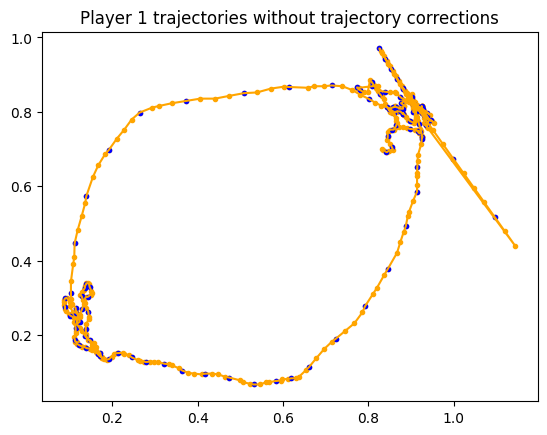

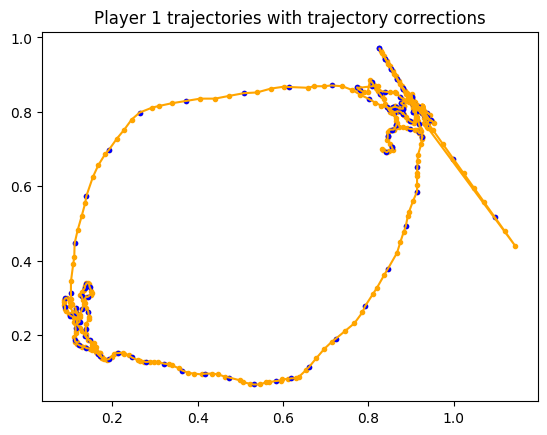

In [283]:
player_index = 0
plot_orig_down(x_orig, x_down, player_index)
plt.title(f"Player {player_index+1} trajectories without trajectory corrections")
plt.show()

plot_orig_down(x_orig, x_down_corr, player_index)
plt.title(f"Player {player_index+1} trajectories with trajectory corrections")
plt.show()

In [284]:
traj = x_down_corr[:, player_index, :]
new_n_data = len(traj) * int(new_fps / old_fps)
tck, u = interpolate.splprep([traj[:,0], traj[:,1]], s = 0.0)
new_x1, new_x2 = interpolate.splev(np.linspace(0, 1, new_n_data), tck)
traj_interp = np.vstack([new_x1, new_x2]).T

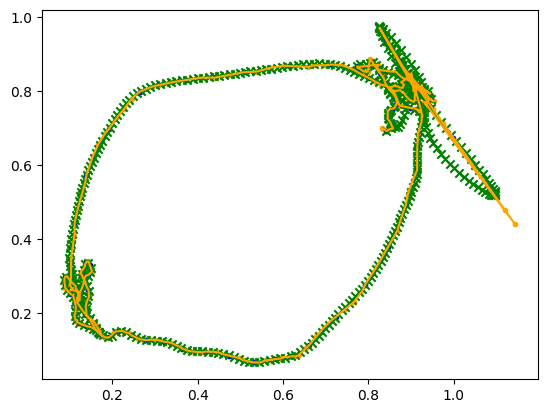

In [285]:
plot_orig_down(x_orig, x_down_corr, player_index)
plt.scatter(traj_interp[:, 0], traj_interp[:, 1], color='green', marker='x')

The correction for interpolation doesn't always work, should use a Gaussian filter. 

For now we only select groups that don't throw errors so we complete the interpolation successfully.

Future work: try [interpolation in pandas](https://opensource.com/article/17/9/messy-sensor-data).

In [349]:
def get_groups_noerr(old_fps):

    gs = groups.copy() 
    player_index = 0
    
    for g in groups:
        x_orig, x_down_corr = load_traj_and_downsample(g, old_fps, correct = True)
        try:
            x_intp = interpolate_all(x_down_corr, old_fps, new_fps)
    
        except Exception as e:
            print(f"{g} failed with {e}")
            gs.remove(g)
            
    return gs

In [354]:
gs = get_groups_noerr(3)
gs

A2 failed with Invalid inputs.
A4 failed with Invalid inputs.
A8 failed with Invalid inputs.
A9 failed with Invalid inputs.
B1 failed with Invalid inputs.
B2 failed with Invalid inputs.
B5 failed with Invalid inputs.
B6 failed with Invalid inputs.


['A3', 'A5', 'A6', 'A10', 'B3', 'B4', 'B7', 'B8', 'B9']

## Try emergence algorithm
Compare raw vs downsampled-and-reconstructed data 

In [385]:
def compare_psi(g, old_fps, new_fps):
    calc_old = emergence.EmergenceCalculator(emergence.compute_macro, 
                use_correction = True, psi_buffer_size = bufs[g], observation_window_size = 120)
    calc_new = emergence.EmergenceCalculator(emergence.compute_macro, 
                use_correction = True, psi_buffer_size = bufs[g], observation_window_size = 120)

    x_orig, x_down_corr = load_traj_and_downsample(g, old_fps, correct = True)
    x_intp = interpolate_all(x_down_corr, old_fps, new_fps)
    psi_old, psi_new = [], []
    ind_old, ind_new = [], []
    num_players = 10

    for x in x_orig:
            psi_old.append(calc_old.update_and_compute(x))    
    for x in x_intp:
            psi_new.append(calc_new.update_and_compute(x))
        
    return psi_old, psi_new

A2 failed with Invalid inputs.
A3 failed with Invalid inputs.
A4 failed with Invalid inputs.
A5 failed with Invalid inputs.
A8 failed with Invalid inputs.
A9 failed with Invalid inputs.
A10 failed with Invalid inputs.
B2 failed with Invalid inputs.
B5 failed with Invalid inputs.
B7 failed with Invalid inputs.
B8 failed with Invalid inputs.


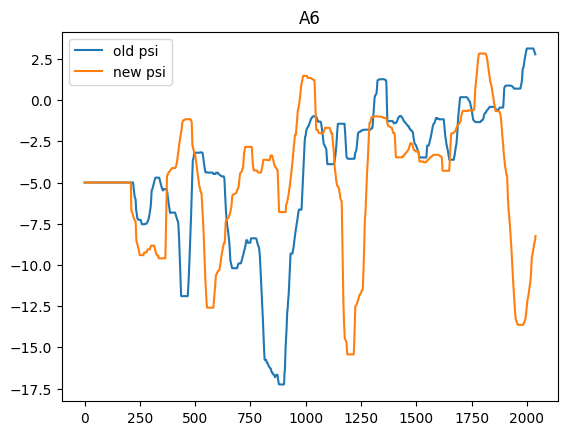

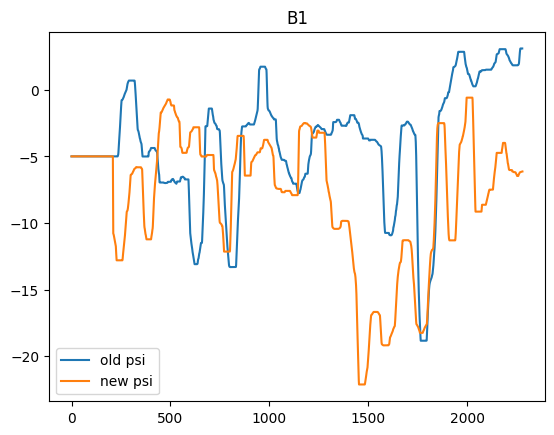

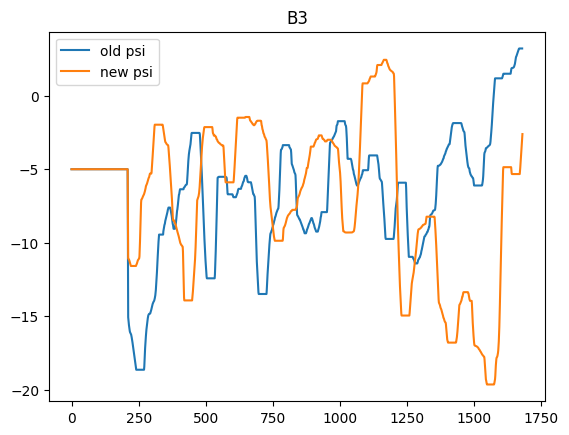

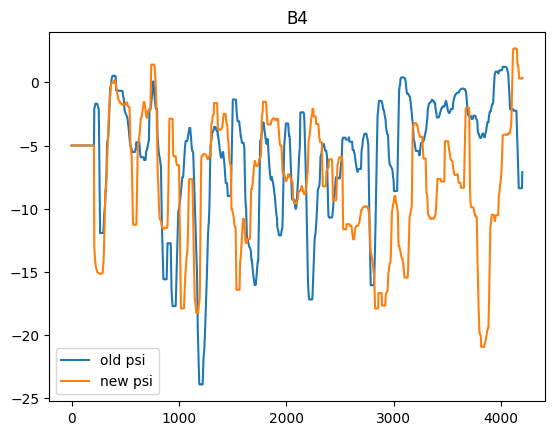

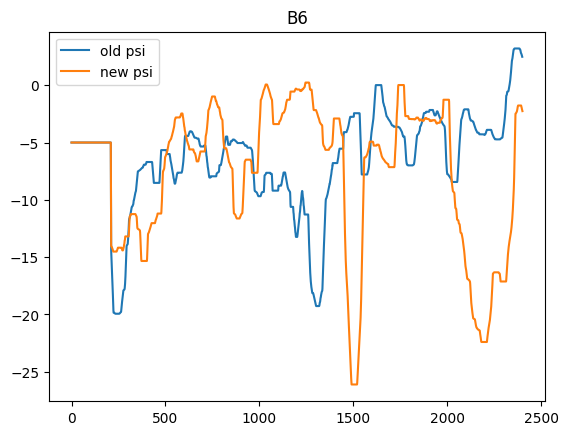

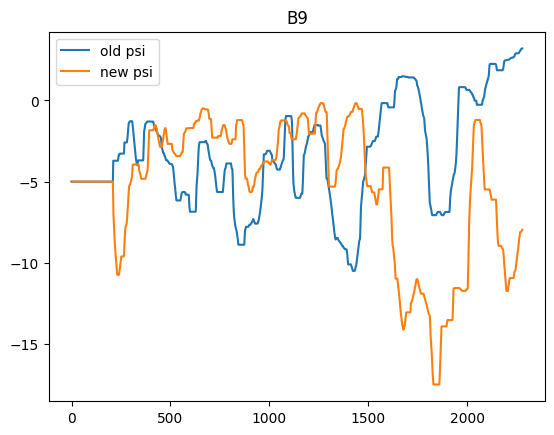

In [386]:
old_fps = 6
gs = get_groups_noerr(old_fps)
for g in gs:
    po, pn = compare_psi(g, old_fps, new_fps)
    plt.plot(po, label="old psi")
    plt.plot(pn, label="new psi")
    plt.title(g)
    plt.legend()
    plt.show()

A2 failed with Invalid inputs.
A4 failed with Invalid inputs.
A8 failed with Invalid inputs.
A9 failed with Invalid inputs.
B1 failed with Invalid inputs.
B2 failed with Invalid inputs.
B5 failed with Invalid inputs.
B6 failed with Invalid inputs.


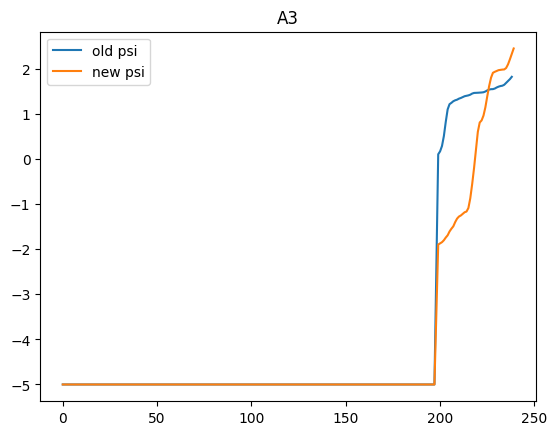

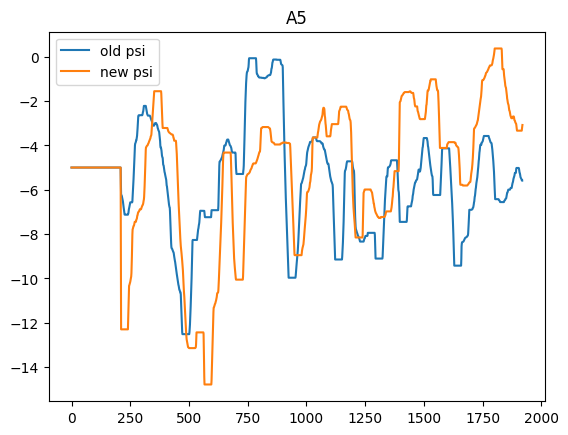

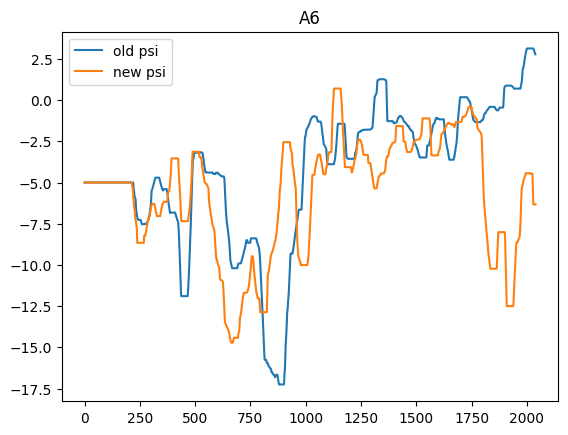

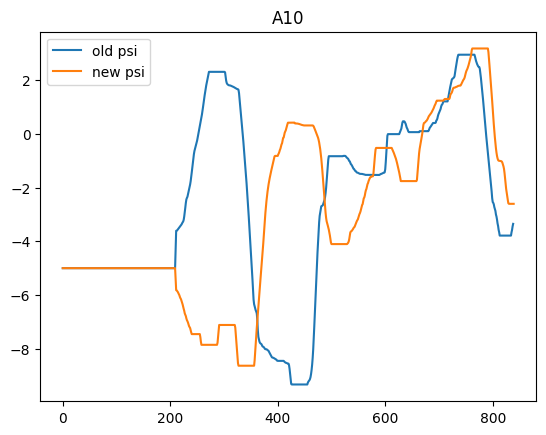

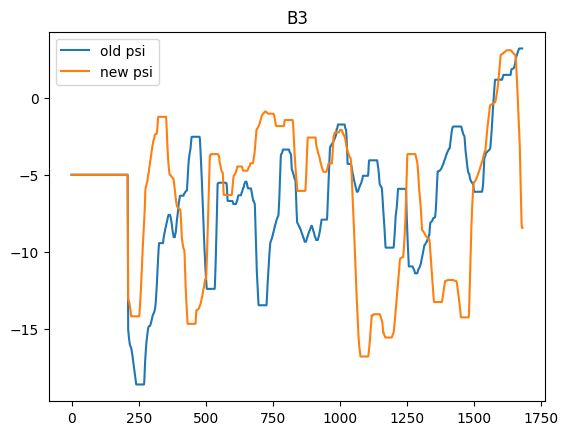

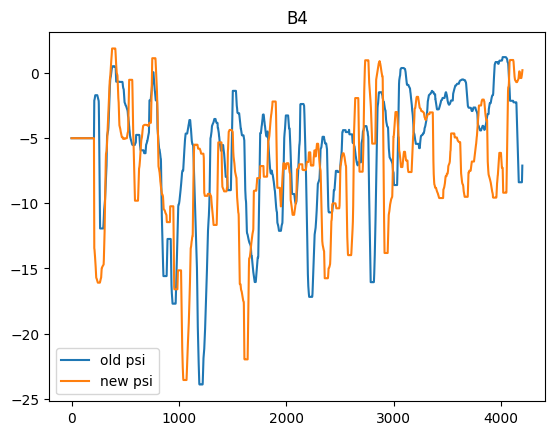

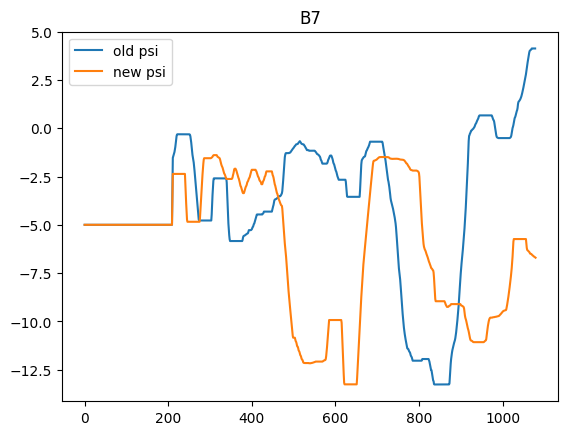

In [ ]:
old_fps = 3
gs = get_groups_noerr(old_fps)
for g in gs:
    po, pn = compare_psi(g, old_fps, new_fps)
    plt.plot(po, label="old psi")
    plt.plot(pn, label="new psi")
    plt.title(g)
    plt.legend()
    plt.show()